## Logit Model
---


In [1]:
%matplotlib inline
import numpy as np
import scipy.stats as st
import pandas as pd
import matplotlib.pyplot as plt
import pymc3 as pm
from IPython.display import display

The following cell generates data from 

$$
 y_i = \begin{cases}
 1, & \text{with probability}\quad \mu_i; \\
 0, & \text{with probability}\quad 1-\mu_i.
 \end{cases}
$$

$$
 \log\frac{\mu_i}{1-\mu_i} = 0.5 x_{1i} - 0.5 x_{2i},\quad i=1,\dots,500.
$$


In [2]:
n = 500
np.random.seed(99)
x1 = st.uniform.rvs(loc=-np.sqrt(3.0), scale=2.0*np.sqrt(3.0), size=n)
x2 = st.uniform.rvs(loc=-np.sqrt(3.0), scale=2.0*np.sqrt(3.0), size=n)
q = st.logistic.cdf(0.5*x1 - 0.5*x2)
y = st.bernoulli.rvs(q)
X = np.stack((np.ones(n), x1, x2), axis=1)

In [3]:
n, k = X.shape
b0 = np.zeros(k)
A0 = 0.01 * np.eye(k)
logit_model = pm.Model()
with logit_model:
    b = pm.MvNormal('b', mu=b0, tau=A0, shape=k)
    idx = pm.math.dot(X, b)
    likelihood = pm.Bernoulli('y', logit_p=idx, observed=y)
n_draws = 5000
n_chains = 4
n_tune = 1000
with logit_model:
    trace = pm.sample(draws=n_draws, chains=n_chains, tune=n_tune, random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [b]
Sampling 4 chains: 100%|██████████| 24000/24000 [00:16<00:00, 1454.59draws/s]


In [4]:
display(pm.summary(trace))

/Users/teruo/.pyenv/versions/miniconda3-latest/envs/bayes/lib/python3.7/site-packages/pymc3/stats.py:991: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
b__0,-0.081701,0.095790,0.000634,-0.265342,0.106731,28119.996390,1.000108
b__1,0.421630,0.096928,0.000571,0.239198,0.619191,28176.304998,1.000002
b__2,-0.487295,0.097324,0.000576,-0.679199,-0.295141,26758.214549,0.999924


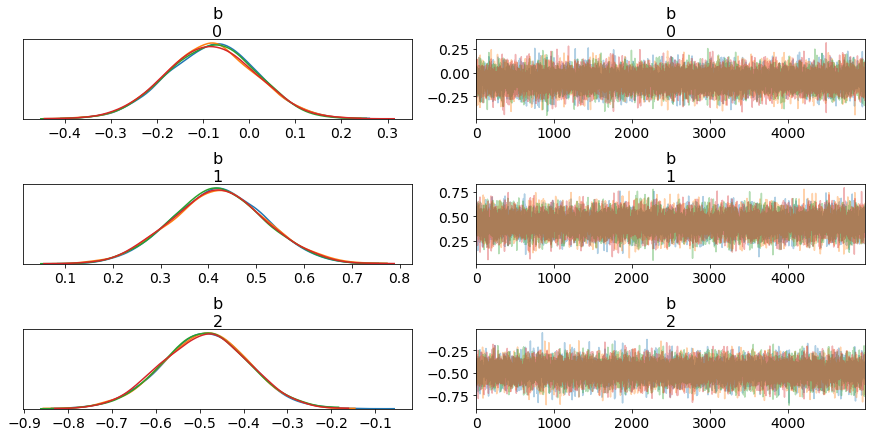

In [5]:
pm.traceplot(trace)
plt.show()

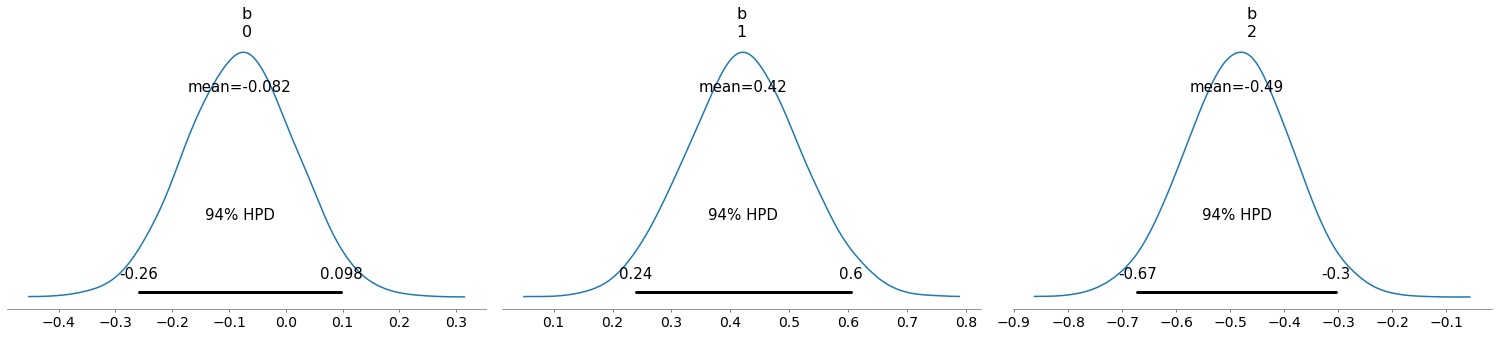

In [6]:
pm.plot_posterior(trace, kind='kde', point_estimate='mean')
plt.show()